In [1]:
from pyM2aia import M2aiaImageHelper
from ctypes import CDLL
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import SimpleITK as sitk
from pathlib import Path
import torch.nn.functional as F
import pandas as pd
import seaborn as sns

lib = CDLL('libM2aiaCoreIO.so')
image = "ew_section3_pos.imzML"
params = "m2PeakPicking.txt"

intensity_count = 0
I = None
pixel = None
with M2aiaImageHelper(lib, image, params) as helper:
    gen = helper.SpectrumIterator()
    pixel = next(gen)[2]
    intensity_count = len(pixel)
    I = helper.GetImage(1088.868, 0.249, np.float32)
    label1 = sitk.ReadImage("1088_868_label1.nrrd")
sitk.WriteImage(I, "1088_868.nrrd")
label1 = sitk.GetArrayFromImage(label1)
A = sitk.GetArrayFromImage(I)
x_size = A.shape[1]
y_size = A.shape[2]
print(A.shape)
print(I.GetSize())
print(intensity_count)


[Thu Dec  9 20:41:56 2021 
3.440] baseline-correction None
[3.440] baseline-correction-hw 50
[3.440] smoothing None
[3.440] smoothing-hw 2
[3.440] normalization None
[3.440] pooling Maximum
[3.440] tolerance 0
[3.440] threads 24
[3.440] Start reading imzML...
[3.440] ImzMLSpectrumImage created!
[3.440] Parsing imzML started ...
[3.619] SciLs 3D tag found
[3.619] 	1 unique z positions found:
0, [3.619] Parsing imzML: 0.178614s
[3.619] Initialize placeholder images and spectra started ...
[3.630] Initialize placeholder images and spectra: 0.00871663s
[3.630] Load external data started ...
[3.632] Load external data: 0.00095495s
[3.632] Continuous Profile
[3.634] Initialize image started ...
[5.744] Initialize image: 0.164157s
[5.854] ImzMLSpectrumImage destroyed!
(1, 169, 224)
(224, 169, 1)
29693


In [2]:
# Welford's online algorithm for calculating mean and variance

# For a new value newValue, compute the new count, new mean, the new M2.
# mean accumulates the mean of the entire dataset
# M2 aggregates the squared distance from the mean
# count aggregates the number of samples seen so far
def update(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2
    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float("nan")
    else:
        (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
        return (mean, variance, sampleVariance)

aggregate = [0, np.zeros((intensity_count)), np.zeros((intensity_count))]
with M2aiaImageHelper(lib, image, params) as helper:
    gen = helper.SpectrumIterator()
    for data in gen:
        i, xs, ys = data
        aggregate = update(aggregate, ys)
im_mean, im_variance, im_sampleVariance = finalize(aggregate)
im_stddev = np.sqrt(im_sampleVariance)
print(im_mean, im_variance, im_sampleVariance)

[5.879] baseline-correction None
[5.879] baseline-correction-hw 50
[5.879] smoothing None
[5.879] smoothing-hw 2
[5.879] normalization None
[5.879] pooling Maximum
[5.879] tolerance 0
[5.879] threads 24
[5.880] Start reading imzML...
[5.880] ImzMLSpectrumImage created!
[5.880] Parsing imzML started ...
[6.086] SciLs 3D tag found
[6.087] 	1 unique z positions found:
0, [6.087] Parsing imzML: 0.203038s
[6.087] Initialize placeholder images and spectra started ...
[6.097] Initialize placeholder images and spectra: 0.00849118s
[6.097] Load external data started ...
[6.098] Load external data: 0.00086021s
[6.098] Continuous Profile
[6.101] Initialize image started ...
[8.281] Initialize image: 0.157397s
[12.069] ImzMLSpectrumImage destroyed!
[0.         0.09790998 0.09859938 ... 0.04207615 0.04146861 0.        ] [0.         0.00735758 0.00790624 ... 0.00170585 0.00177776 0.        ] [0.         0.00735784 0.00790652 ... 0.00170591 0.00177782 0.        ]


In [3]:
print(f"torch cuda version: {torch.version.cuda}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch cuda version: 11.3
cuda


In [4]:
latent_size = 16
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()

        # pooling layer
        self.pool = nn.MaxPool1d(2)
        
        # encoding
        self.conv2 = nn.Conv1d(4, 16, 3, padding="same")
        self.conv1 = nn.Conv1d(1, 4, 3, padding="same")
        self.conv3 = nn.Conv1d(16, 64, 3, padding="same")
        self.conv4 = nn.Conv1d(64, 256, 3, padding="same")
        self.conv5 = nn.Conv1d(256, 1024, 3, padding="same")
        self.enc1 = nn.Linear(1024*1000, latent_size*2)
        
        # decoding
        self.dec1 = nn.Linear(latent_size, 1024*1000)
        self.deconv1 = nn.ConvTranspose1d(1024, 256, 2, stride=2)
        self.deconv2 = nn.ConvTranspose1d(256, 64, 2, stride=2)
        self.deconv3 = nn.ConvTranspose1d(64, 16, 2, stride=2)
        self.deconv4 = nn.ConvTranspose1d(16, 4, 2, stride=2)
        self.deconv5 = nn.ConvTranspose1d(4, 1, 2, stride=2)

    def encode(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = self.pool(torch.tanh(self.conv3(x)))
        x = self.pool(torch.tanh(self.conv4(x)))
        x = self.pool(torch.tanh(self.conv5(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.enc1(x)

        # sampling
        x = x.view(-1, 2, latent_size)
        mu = x[:, 0, :]
        logvar = x[:, 1, :]
        x = self.reparameterize(mu, logvar)
        return x, mu, logvar

    def decode(self, x):
        x = torch.tanh(self.dec1(x))
        x = x.view(-1, 1024, 1000)
        x = torch.tanh(self.deconv1(x))
        x = torch.tanh(self.deconv2(x))
        x = torch.tanh(self.deconv3(x))
        x = torch.tanh(self.deconv4(x))
        x = self.deconv5(x)
        return x

    def forward(self, x):
        # encoding
        x, mu, logvar = self.encode(x)

        # decoding
        x = self.decode(x)
        return x, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample

def train(batch):
    optimizer.zero_grad()
    reconstruction, mu, logvar = model(batch)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = loss_function(reconstruction, batch) # reconstruction loss
    loss = loss + kld
    loss.backward()
    optimizer.step()
    return loss

In [5]:
model = ConvAE()
if torch.cuda.device_count() > 1:
    print(torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)
model.to(device)
model_params = Path("/home/dbogacz/Development/pyM2aia/tests/model_params_conv_kld.pt")
print(f"model_params already exist? {model_params.is_file()}")
if model_params.is_file():
    model.load_state_dict(torch.load(model_params))
print(f"model on cuda? {next(model.parameters()).is_cuda}")
optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss(reduction="sum")

2 GPUs
model_params already exist? False
model on cuda? True


In [6]:
iterations = 1000
total_loss = []
kld_loss = []
rec_loss = []
with M2aiaImageHelper(lib, image, params) as helper:

    # training
    batch_iter = helper.SpectrumRandomBatchIterator(32)
    for i in range(iterations):
        batch = next(batch_iter)
        batch -= im_mean # data zero centering
        batch /= (im_stddev + 1e-10) # data normalization
        batch = torch.unsqueeze(torch.from_numpy(batch).to(device), 1)
        batch = F.pad(batch, (0, 2307), "constant", 0)
        loss = train(batch)
        total_loss.append(loss.item())

        if i % (iterations//10) == 0:
            print(f"{i:6d}: loss: {loss.item():3.4f}")
    
    # save learned model parameters
    # torch.save(model.state_dict(), "/home/dbogacz/Development/pyM2aia/tests/model_params_conv_kld.pt")

    # print("creating .nrrd file...")
    # imgData = np.zeros((1, x_size, y_size, latent_size))
    # gen = helper.SpectrumIterator()
    # for data in gen:
    #     id, xs, ys = data
    #     x, y, z = helper.GetPixelPosition(id)
    #     ys -= im_mean # data zero centering
    #     ys /= (im_stddev + 1e-10) # data normalization
    #     ys = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(ys).to(device), 0), 0)
    #     ys = F.pad(ys, (0, 2307), "constant", 0)
    #     with torch.no_grad():
    #         latent_vector = model.module.encode(ys)
    #     imgData[z, y, x, :] = latent_vector.cpu().numpy()
    # im = sitk.GetImageFromArray(imgData)
    # sitk.WriteImage(im, "/home/dbogacz/Development/pyM2aia/tests/worm_padded_conv_1024.nrrd")

[14.562] baseline-correction None
[14.562] baseline-correction-hw 50
[14.562] smoothing None
[14.562] smoothing-hw 2
[14.562] normalization None
[14.562] pooling Maximum
[14.562] tolerance 0
[14.562] threads 24
[14.564] Start reading imzML...
[14.564] ImzMLSpectrumImage created!
[14.564] Parsing imzML started ...
[14.750] SciLs 3D tag found
[14.750] 	1 unique z positions found:
0, [14.750] Parsing imzML: 0.1839s
[14.750] Initialize placeholder images and spectra started ...
[14.760] Initialize placeholder images and spectra: 0.00822194s
[14.760] Load external data started ...
[14.761] Load external data: 0.000862892s
[14.761] Continuous Profile
[14.763] Initialize image started ...
[16.945] Initialize image: 0.155363s
     0: loss: 806827.8750
   100: loss: 1611041.8750
   200: loss: 1967077.7500
   300: loss: 1479631.1250
   400: loss: 1357939.5000
   500: loss: 1646634.2500
   600: loss: 1275346.5000
   700: loss: 1514488.2500
   800: loss: 1287298.2500
   900: loss: 1420469.5000
[83

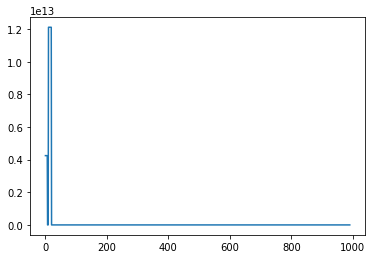

In [7]:
array = np.array(total_loss)
array = np.convolve(array, np.full((10), 0.1), "valid")
plt.figure(1)
plt.plot(array)

[83.911] baseline-correction None
[83.911] baseline-correction-hw 50
[83.911] smoothing None
[83.911] smoothing-hw 2
[83.912] normalization None
[83.912] pooling Maximum
[83.912] tolerance 0
[83.912] threads 24
[83.912] Start reading imzML...
[83.912] ImzMLSpectrumImage created!
[83.912] Parsing imzML started ...
[84.099] SciLs 3D tag found
[84.100] 	1 unique z positions found:
0, [84.100] Parsing imzML: 0.186435s
[84.100] Initialize placeholder images and spectra started ...
[84.110] Initialize placeholder images and spectra: 0.00834636s
[84.110] Load external data started ...
[84.111] Load external data: 0.000610091s
[84.111] Continuous Profile
[84.112] Initialize image started ...
[86.056] Initialize image: 0.17797s


/tmp/ipykernel_3396721/3557814922.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 28277 + 1) instead
  id = int(np.random.random_integers(0, helper.GetNumberOfSpectra()-1, 1))


[88.745] ImzMLSpectrumImage destroyed!
creating scatterplot matrix...


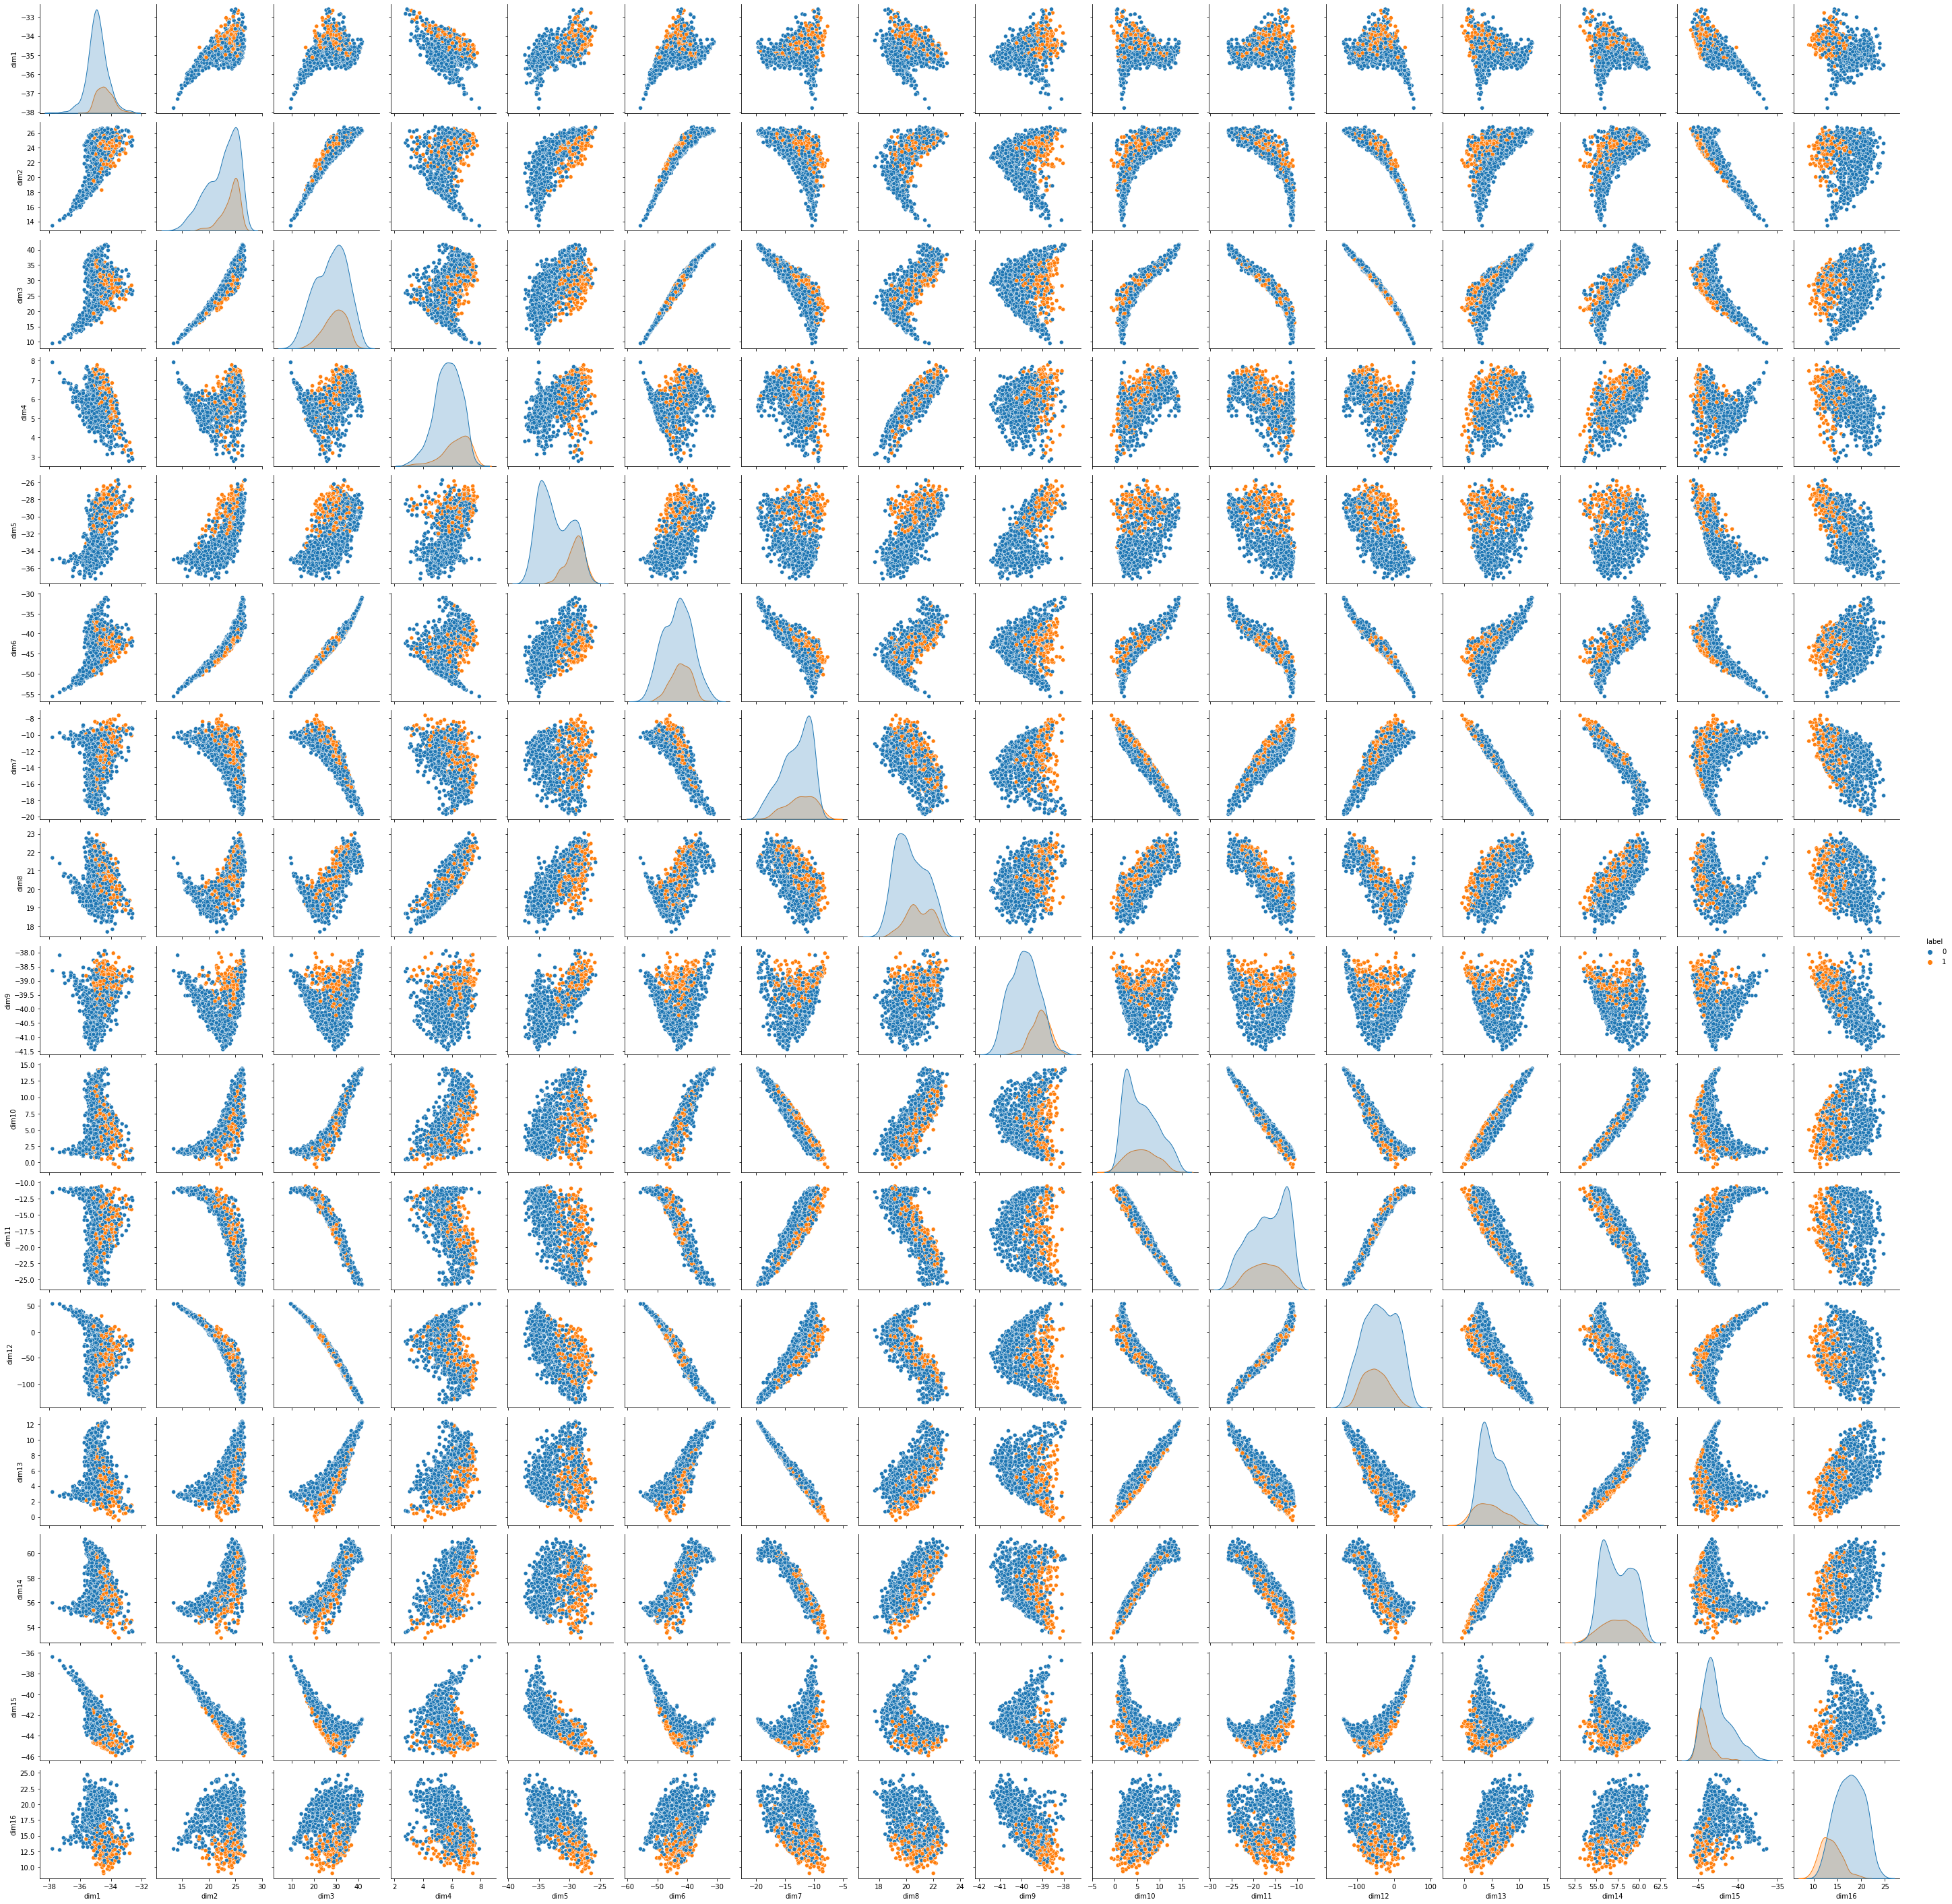

In [8]:
data = []
with M2aiaImageHelper(lib, image, params) as helper:
    for i in range(2000):
        id = int(np.random.random_integers(0, helper.GetNumberOfSpectra()-1, 1))
        xs, ys = helper.GetSpectrum(id)
        x, y, z = helper.GetPixelPosition(id)
        label = str(label1[z, y, x])
        ys -= im_mean # data zero centering
        ys /= (im_stddev + 1e-10) # data normalization
        ys = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(ys).to(device), 0), 0)
        ys = F.pad(ys, (0, 2307), "constant", 0)
        with torch.no_grad():
            ys, mu, logvar = model.module.encode(ys)
            ys = torch.squeeze(ys, 0).cpu().numpy()
        ys = list(ys)
        ys.append(label)
        data.append(ys)
columns = ["dim" + str(i+1) for i in range(16)]
columns.append("label")
df = pd.DataFrame(data, columns = columns)
print("creating scatterplot matrix...")
sns.pairplot(df, hue="label")